# Clustering Notebook: 

#### DBScan - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

#### Nearest Neighbors - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

#### Overview of DB Scan - https://medium.com/@agarwalvibhor84/lets-cluster-data-points-using-dbscan-278c5459bee5

#### DBScan Article for code below - https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

#### Notebook from above article - https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb



In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [2]:
### Load File. 
emyear20xx = pd.read_csv('/Users/AlfHaugen/Python/Wildfire_Data/9 Missoula Emisions Data RDS-2017-0039/Emissions_Year/emissions_year2003to2015.csv')

In [3]:
print(emyear20xx['year'].unique())

[2008 2009 2013 2007 2006 2012 2004 2010 2011 2005 2015 2014 2003]


In [4]:
emyear20xx.shape

(7254534, 22)

In [5]:
### Remove zero value features noted during data review. 
indexNames = emyear20xx[(emyear20xx.prefire_fuel == 0) & (emyear20xx.consumed_fuel == 0) & (emyear20xx.ECO2 == 0)].index
emyear20xx.drop(indexNames , inplace=True)

In [6]:
emyear20xx.shape

(5960572, 22)

In [7]:
emyear20xx.head()

,id,year,doy,longitude,latitude,grid10k,covertype,fuelcode,area_burned,prefire_fuel,...,ECO,ECH4,EPM2.5,cwd_frac,duff_frac,fuel_moisture_class,burn_source,burnday_source,BSEV,BSEV_flag
0,0,2008,359,-81.0384,25.1958,4536,3,1600,0.0,6220.097576,...,153.981344,4.499455,23.797117,0.023231,0.082115,3,1,81,1,0
1,1,2008,359,-81.0404,25.1984,4536,3,1600,62500.0,6220.097576,...,157.185824,4.593092,24.292355,0.022757,0.080441,3,1,81,2,0
2,2,2008,359,-81.0380,25.1981,4536,3,1600,0.0,6220.097576,...,153.981344,4.499455,23.797117,0.023231,0.082115,3,1,81,1,0
4,4,2008,359,-81.0594,25.2035,4536,3,1600,0.0,6220.097576,...,153.981344,4.499455,23.797117,0.023231,0.082115,3,1,81,1,0
5,5,2008,359,-81.0570,25.2032,4536,3,1600,62500.0,6220.097576,...,157.185824,4.593092,24.292355,0.022757,0.080441,3,1,81,2,0


## Set Year for DataSet and pair down data

In [65]:
emyear = 2007

In [66]:
### Variable to capture a single year of data for clustering. 
### Example - emyear20xx = emyear20xx[(emyear20xx.year == 2005) & (emdata.doy > 181) & (emdata.doy < 213)]
emyearset20xx = emyear20xx[(emyear20xx.year == emyear)]
print('There are {:,} rows'.format(len(emyearset20xx)))

There are 640,039 rows


In [67]:
emyearset20xx.tail(10)

,id,year,doy,longitude,latitude,grid10k,covertype,fuelcode,area_burned,prefire_fuel,...,ECO,ECH4,EPM2.5,cwd_frac,duff_frac,fuel_moisture_class,burn_source,burnday_source,BSEV,BSEV_flag
2080921,766642,2007,177,-120.2088,48.3765,128214,3,1220,62500.0,4534.187262,...,450.203370,25.319708,77.177721,0.154208,0.257893,2,4,78,3,1
2080922,766643,2007,177,-120.2055,48.3771,128214,1,1,62500.0,61.871472,...,4.027833,0.154208,0.586913,0.000000,0.000000,2,4,78,3,1
2080923,766644,2007,177,-120.2128,48.3781,128214,2,2,62500.0,676.775268,...,42.636842,1.632382,6.212797,0.000000,0.000000,2,4,78,2,1
2080924,766645,2007,177,-120.2096,48.3787,128214,2,2,62500.0,675.766494,...,42.573289,1.629949,6.203536,0.000000,0.000000,2,4,78,3,1
2080925,766646,2007,177,-120.2064,48.3793,128214,2,2,62500.0,690.449760,...,43.498335,1.665365,6.338329,0.000000,0.000000,2,4,78,3,1
2080926,766647,2007,177,-120.2104,48.3809,128214,2,2,62500.0,714.099906,...,44.988294,1.722409,6.555437,0.000000,0.000000,2,4,78,2,1
2080927,766648,2007,219,-118.2374,48.9904,129613,3,1200,62500.0,6424.431099,...,600.019765,33.745472,102.860531,0.212021,0.178167,3,4,77,4,1
2080929,766650,2007,139,-119.3991,48.8640,129604,1,1,0.0,136.857006,...,8.909391,0.341102,1.298226,0.000000,0.000000,3,4,78,1,1
2080930,766651,2007,196,-120.7040,48.9275,130978,3,1360,0.0,2673.497587,...,230.753619,12.977722,39.557763,0.191861,0.264404,2,4,78,1,1
2080931,766652,2007,196,-120.7007,48.9281,130978,3,1260,62500.0,6989.973251,...,629.822967,35.421623,107.969652,0.321165,0.245802,2,4,78,3,1


In [68]:
kms_per_radian = 3956
### 3956 for miles, 6371.0088 for kilometers
print(kms_per_radian)

3956


## Compute DBSCAN

 #####   eps is the physical distance from each point that forms its neighborhood
#####    min_samples is the min cluster size, otherwise it's noise - set to 1 so we get no noise

##### Extract the lat, lon columns into a numpy matrix of coordinates, then convert to radians when you call fit, for use by scikit-learn's haversine metric.

In [69]:
coords = emyearset20xx.as_matrix(columns=['latitude', 'longitude'])
epsilon = 1.5 / kms_per_radian

/Users/AlfHaugen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


## Defining the Clustering Functions

In [70]:
emyear

2007

In [71]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(emyearset20xx), num_clusters, 100*(1 - float(num_clusters) / len(emyearset20xx)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))


Clustered 640,039 points down to 8,945 clusters, for 98.6% compression in 110.69 seconds
Silhouette coefficient: 0.269


## Results from Clustering:
### Emissions Data from USDA:
##### 2003 - Clustered 317,353 points down to 6,231 clusters, for 98.0% compression in 44.70 seconds
Silhouette coefficient: 0.491
##### 2004 - Clustered 164,634 points down to 6,568 clusters, for 96.0% compression in 21.16 seconds
Silhouette coefficient: 0.605
##### 2005 - Clustered 399,828 points down to 9,010 clusters, for 97.7% compression in 76.10 seconds
Silhouette coefficient: 0.419
##### 2007 - Clustered 640,039 points down to 8,945 clusters, for 98.6% compression in 110.69 seconds
Silhouette coefficient: 0.269
#### 2008 - 

In [72]:
# turn the clusters into a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [73]:
# Print clusters to see what's in it:: ok, looks like all the coordindates for cluster. 
clusters.tail(2)

8943                          [[48.864, -119.3991]]
8944    [[48.9275, -120.704], [48.9281, -120.7007]]
dtype: object

# Moving original data points placed into clusters into DataFrame

In [74]:
ab = list(zip(clusters[0]))
ab = len(ab)
print('Number (len) of Clusters from results = ', len(clusters))
print('Number of cluster datapoints in the first Cluster = ', ab)

Number (len) of Clusters from results =  8945
Number of cluster datapoints in the first Cluster =  3


In [75]:
### Loop to pull in the cluster points that make up each Cluster represented in the Series 'Clusters'.
def preparecluster(row, clusterseries):
    clusterDF = pd.DataFrame(clusterseries[0]) 
    clusterDF = clusterDF.assign(ClusterNum=row) 
    row = 1
    while row < len(clusterseries):
        clusterdata = (clusterseries[row])
        clusterDFTemp = pd.DataFrame(clusterdata)
        clusterDFTemp = clusterDFTemp.assign(ClusterNum=row) 
        clusterDF = clusterDF.append(clusterDFTemp, ignore_index=True)
        row = row + 1
    return clusterDF

In [76]:
### Viewing results of dataframe consolidation and adding year to 
groupedclusters = preparecluster(0,clusters)
groupedclusters = groupedclusters.assign(Year=2007) 
groupedclusters.tail()

,0,1,ClusterNum,Year
640034,48.3809,-120.2104,8941,2007
640035,48.9904,-118.2374,8942,2007
640036,48.8640,-119.3991,8943,2007
640037,48.9275,-120.7040,8944,2007
640038,48.9281,-120.7007,8944,2007


In [77]:
groupedclusters.to_csv('/Users/AlfHaugen/Python/Wildfire_Data/FireExports/Emclustermakeup_2007.csv', encoding='utf-8')

## Find the point in each cluster that is closest to its centroid

DBSCAN clusters may be non-convex. This technique just returns one representative point from each cluster. First get the lat,lon coordinates of the cluster's centroid (shapely represents the first coordinate in the tuple as x and the second as y, so lat is x and lon is y here). Then find the member of the cluster with the smallest great circle distance to the centroid.


In [78]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

In [79]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
latlon = zip(*centermost_points)
print(latlon)

In [80]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
latitude, longitude = zip(*centermost_points)

In [81]:
print(latitude[1:5], longitude[1:5])

(25.7279, 25.7478, 25.8822, 25.8898) (-80.5475, -80.5264, -81.2633, -81.2045)


In [82]:
# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'longitude':longitude, 'latitude':latitude})
rep_points.head()

,longitude,latitude
0,-80.5223,25.7149
1,-80.5475,25.7279
2,-80.5264,25.7478
3,-81.2633,25.8822
4,-81.2045,25.8898


## Pulling related data for new Cluster Points and saving to CSV

In [83]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe

rs = rep_points.apply(lambda row: emyearset20xx[(emyearset20xx['latitude']==row['latitude']) & (emyearset20xx['longitude']==row['longitude'])].iloc[0], axis=1)
rs.to_csv('/Users/AlfHaugen/Python/Wildfire_Data/FireExports/Emissions2007_DBScan_Clusters.csv', encoding='utf-8')
rs.tail()

,id,year,doy,longitude,latitude,grid10k,covertype,fuelcode,area_burned,prefire_fuel,...,ECO,ECH4,EPM2.5,cwd_frac,duff_frac,fuel_moisture_class,burn_source,burnday_source,BSEV,BSEV_flag
8940,766639.0,2007.0,224.0,-116.6763,48.9172,127780.0,3.0,1300.0,62500.0,11715.036749,...,970.697355,54.592603,166.405261,0.411771,0.244087,2.0,4.0,78.0,3.0,1.0
8941,766642.0,2007.0,177.0,-120.2088,48.3765,128214.0,3.0,1220.0,62500.0,4534.187262,...,450.203370,25.319708,77.177721,0.154208,0.257893,2.0,4.0,78.0,3.0,1.0
8942,766648.0,2007.0,219.0,-118.2374,48.9904,129613.0,3.0,1200.0,62500.0,6424.431099,...,600.019765,33.745472,102.860531,0.212021,0.178167,3.0,4.0,77.0,4.0,1.0
8943,766650.0,2007.0,139.0,-119.3991,48.8640,129604.0,1.0,1.0,0.0,136.857006,...,8.909391,0.341102,1.298226,0.000000,0.000000,3.0,4.0,78.0,1.0,1.0
8944,766652.0,2007.0,196.0,-120.7007,48.9281,130978.0,3.0,1260.0,62500.0,6989.973251,...,629.822967,35.421623,107.969652,0.321165,0.245802,2.0,4.0,78.0,3.0,1.0


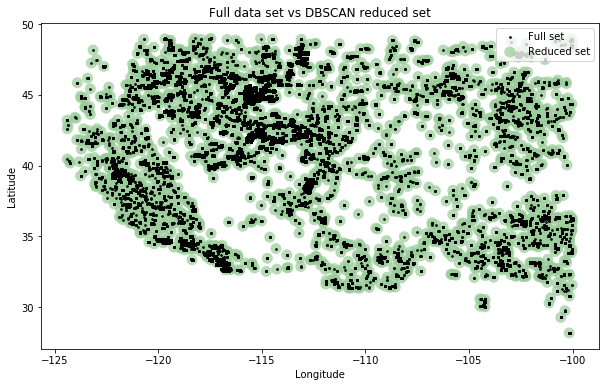

In [130]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(emyearset20xx['longitude'], emyearset20xx['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()